# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import sys
print("Python %s" % sys.version)
from collections import deque

Python 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.5


In [3]:
import gym
print("OpenAI Gym %s" % gym.__version__)
from gym import wrappers

OpenAI Gym 0.14.0


In [4]:
import matplotlib
print("matplotlib %s" % matplotlib.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib 3.1.1


In [5]:
import torch
print("PyTorch %s" % torch.__version__)
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

PyTorch 1.2.0


In [25]:
from IPython import display

### 2. Define the Architecture of the Policy

In [6]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(4,)
action space: Discrete(2)


In [7]:
env

<TimeLimit<CartPoleEnv<CartPole-v0>>>

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
device

device(type='cuda', index=0)

In [11]:
class Policy(nn.Module):
    def __init__(self, device, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### 3. Train the Agent with REINFORCE

In [40]:
policy = Policy(device).to(device)

In [41]:
policy

Policy(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

In [42]:
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

In [43]:
def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(
                i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 12.10
Episode 200	Average Score: 19.37
Episode 300	Average Score: 21.51
Episode 400	Average Score: 46.28
Episode 500	Average Score: 70.34
Episode 600	Average Score: 112.47
Episode 700	Average Score: 125.36
Environment solved in 684 episodes!	Average Score: 195.45


```
while sleep 0.2; do
nvidia-smi --query-gpu=name,index,temperature.gpu,\
utilization.gpu,utilization.memory,\
memory.total,memory.free,memory.used --format=csv,noheader
done
```

```
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 12 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 12 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 13 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 13 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 17 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 13 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 13 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 13 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 15 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 15 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
GeForce GTX 1060, 0, 60, 14 %, 1 %, 6078 MiB, 5138 MiB, 940 MiB
```

### 4. Plot the Scores

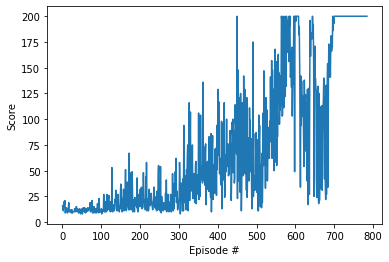

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [45]:
device = torch.device("cpu")
device

device(type='cpu')

In [46]:
policy.device = device

In [47]:
policy = policy.to(device)

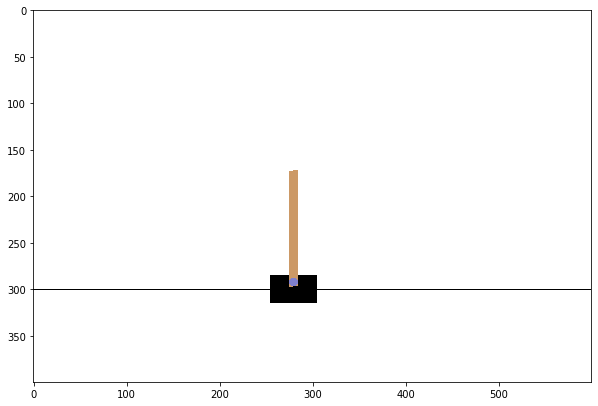

In [48]:
plt.figure(figsize=(10,10))
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for t in range(1000):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

## Hardware Specifications and Software Versions

In [27]:
%%bash
cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [28]:
%%bash
nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [29]:
%%bash
nvidia-smi

Fri Oct  4 22:29:36 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8    11W /  N/A |    947MiB /  6078MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [30]:
%%bash
pip freeze

atari-py==0.2.6
attrs==19.1.0
backcall==0.1.0
bleach==3.1.0
box2d-py==2.3.8
certifi==2019.6.16
cffi==1.12.3
cloudpickle==1.2.2
cycler==0.10.0
Cython==0.29.13
decorator==4.4.0
defusedxml==0.6.0
entrypoints==0.3
future==0.17.1
glfw==1.8.3
gym==0.14.0
imageio==2.5.0
ipykernel==5.1.2
ipython==7.8.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.15.1
Jinja2==2.10.1
jsonschema==3.0.2
jupyter==1.0.0
jupyter-client==5.3.1
jupyter-console==6.0.0
jupyter-core==4.5.0
kiwisolver==1.1.0
lockfile==0.12.2
MarkupSafe==1.1.1
matplotlib==3.1.1
mistune==0.8.4
mkl-fft==1.0.14
mkl-random==1.0.2
mkl-service==2.3.0
mujoco-py==2.0.2.5
nbconvert==5.5.0
nbformat==4.4.0
notebook==6.0.1
numpy==1.16.5
olefile==0.46
opencv-python==4.1.1.26
pandocfilters==1.4.2
parso==0.5.1
pexpect==4.7.0
pickleshare==0.7.5
Pillow==6.1.0
prometheus-client==0.7.1
prompt-toolkit==2.0.9
ptyprocess==0.6.0
pycparser==2.19
pyglet==1.3.2
Pygments==2.4.2
pyparsing==2.4.2
pyrsistent==0.14.11
python-dateutil==2.8.0
pytz==2019.2
PyYAML==5.1